# 고급 이미지 분류(CNN) - 말과사람 (실습)

Convolution Neural Network (합성곱 신경망)를 활용한 이미지 분류 (Image Classification)

## 확인

1. GPU 옵션 켜져 있는지 확인할 것!!! (수정 - 노트설정 - 하드웨어설정 (GPU))

## 순서

1. **import**: 필요한 모듈 import
2. **전처리**: 학습에 필요한 데이터 전처리를 수행합니다.
3. **모델링(model)**: 모델을 정의합니다.
4. **컴파일(compile)**: 모델을 생성합니다.
5. **학습 (fit)**: 모델을 학습시킵니다.

## 문제

이 작업에서는 다음을 사용하여 말이나 사람을위한 분류기를 만들어야합니다.

최종 레이어에 **sigmoid에 의해 활성화 된 1 개의 뉴런**이 있는지 확인하십시오

중요 : 테스트에는 **300x300 크기의 이미지**가 사용됩니다.
3 바이트 색상 심도이므로 입력 레이어를 수용하도록 설계하십시오

-----------------------------------


# 실습

## STEP 1. import 

**[코드]**

In [ ]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image

# 필요한 모듈을 import 합니다.
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint





## STEP 1. Load Dataset

말과 사람을 구분하는 **이진 분류 (Binary Classification)** 문제입니다.

In [ ]:
_TRAIN_URL = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"
_TEST_URL = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"

urllib.request.urlretrieve(_TRAIN_URL, 'horse-or-human.zip')

local_zip = 'horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/horse-or-human/')
zip_ref.close()

urllib.request.urlretrieve(_TEST_URL, 'validation-horse-or-human.zip')
local_zip = 'validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/validation-horse-or-human/')
zip_ref.close()

**데이터 셋 시각화**

Found 1027 images belonging to 2 classes.
(128, 300, 300, 3) (128, 2)
[1. 0.]


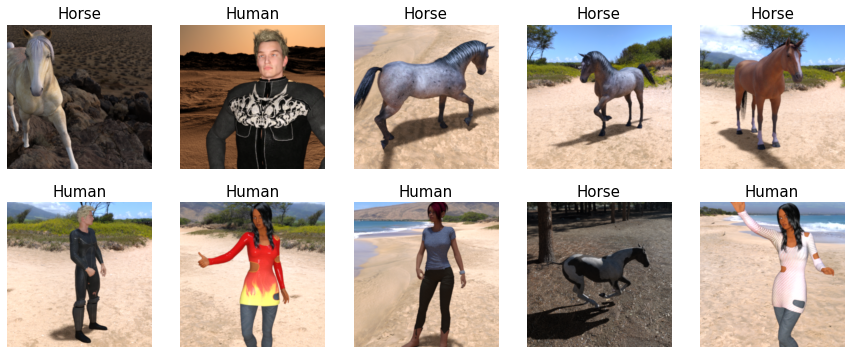

In [ ]:
import matplotlib.pyplot as plt

class_map = {
    0: 'Horse',
    1: 'Human', 
}

original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory('tmp/horse-or-human/', 
                                                          batch_size=128, 
                                                          target_size=(300, 300), 
                                                          class_mode='categorical'
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    break
plt.show()

## STEP 2. 전처리 (ImageDataGenerator)

데이터셋의 경로를 지정해 주세요 (root 폴더의 경로를 지정하여야 합니다.)


**[코드]**

In [ ]:
TRAINING_DIR = "tmp/horse-or-human/"
VALIDATION_DIR = "tmp/validation-horse-or-human/"

`ImageDataGenerator`를 정의합니다.

다음의 옵션 값들로 Image Aumentation(이미지 변형) 옵션을 적절히 조절해 주세요

* `rescale`: 이미지의 픽셀 값을 조정
* `rotation_range`: 이미지 회전
* `width_shift_range`: 가로 방향으로 이동
* `height_shift_range`: 세로 방향으로 이동
* `shear_range`: 이미지 굴절
* `zoom_range`: 이미지 확대
* `horizontal_flip`: 횡 방향으로 이미지 반전
* `fill_mode`: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
* `validation_split`: validation set의 구성 비율

**[코드]**

In [ ]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', 
    )



**참고** validation의 ImageDataGenerator는 `rescale=1/255`외 다른 옵션은 적용하지 않습니다.

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./ 255)




ImageDataGenerator를 잘 만들어 주었다면, `flow_from_directory`로 이미지를 어떻게 공급해 줄 것인가를 지정해 주어야합니다.

* train / validation set 전용 generator를 별도로 정의합니다.
* `batch_size`를 정의합니다.
* `target_size`를 정의합니다. (300 x 300). 이미지를 알아서 타겟 사이즈 만큼 잘라내어 공급합니다.
* `class_mode`는 출력층의 **activation**이 `softmax`인 경우 'categorical', `sigmoid`인 경우 'binary'를 지정합니다.

**training_generator**에 대한 `from_from_directory`를 정의합니다.

**[코드]**

In [ ]:
train_generator =  training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=32, 
                                                          target_size=(300, 300), 
                                                          class_mode='binary', 

                                                         )




Found 1027 images belonging to 2 classes.


**validation_generator**에 대한 `from_from_directory`를 정의합니다.

**[코드]**

In [ ]:
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                          batch_size=32, 
                                                          target_size=(300, 300), 
                                                          class_mode='binary',
                                                         )





Found 256 images belonging to 2 classes.


## STEP 3. 모델 정의 (Sequential)

**[코드]**

In [ ]:
model = Sequential([
    # Conv2D, MaxPooling2D 조합으로 층을 쌓습니다. 첫번째 입력층의 input_shape은 (150, 150, 3)으로 지정합니다.
    Conv2D(64, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    # 2D -> 1D로 변환을 위하여 Flatten 합니다.
    Flatten(), 
    # 과적합 방지를 위하여 Dropout을 적용합니다.
    Dropout(0.5),
    Dense(512, activation='relu'),
    # Classification을 위한 Softmax 
    # 출력층의 갯수는 클래스의 갯수와 동일하게 맞춰줍니다 (3개), activation도 잊지마세요!
    Dense(1, activation='sigmoid'),








])

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_115 (Conv2D)         (None, 298, 298, 64)      1792      
                                                                 
 conv2d_116 (Conv2D)         (None, 296, 296, 64)      36928     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 148, 148, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_117 (Conv2D)         (None, 146, 146, 64)      36928     
                                                                 
 conv2d_118 (Conv2D)         (None, 144, 144, 64)      36928     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 72, 72, 64)       0         
 g2D)                                                 

## STEP 4. 컴파일 (compile)

1. `optimizer`는 가장 최적화가 잘되는 알고리즘인 'adam'을 사용합니다.
2. `loss`는 무엇을 지정하면 좋을까요?
3. `metrics`를 'acc' 혹은 'accuracy'로 지정하면, 학습시 정확도를 모니터링 할 수 있습니다.

**[코드]**

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

## STEP 5. ModelCheckpoint

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

**[코드]**

In [ ]:
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

## STEP 6. 학습 (fit)

**[코드]**

In [ ]:
epochs=25

In [ ]:
model.fit(train_generator, 
          validation_data=(validation_generator),
          epochs=epochs,
          callbacks=[checkpoint],
          )

Epoch 1/25
33/33 [==============================] - ETA: 0s - loss: 0.6970 - acc: 0.5044
Epoch 1: val_loss improved from inf to 0.69210, saving model to tmp_checkpoint.ckpt
33/33 [==============================] - 33s 905ms/step - loss: 0.6970 - acc: 0.5044 - val_loss: 0.6921 - val_acc: 0.5000
Epoch 2/25
33/33 [==============================] - ETA: 0s - loss: 0.6540 - acc: 0.6047
Epoch 2: val_loss improved from 0.69210 to 0.62295, saving model to tmp_checkpoint.ckpt
33/33 [==============================] - 28s 877ms/step - loss: 0.6540 - acc: 0.6047 - val_loss: 0.6229 - val_acc: 0.4961
Epoch 3/25
33/33 [==============================] - ETA: 0s - loss: 0.5784 - acc: 0.6796
Epoch 3: val_loss did not improve from 0.62295
33/33 [==============================] - 29s 868ms/step - loss: 0.5784 - acc: 0.6796 - val_loss: 1.0977 - val_acc: 0.5000
Epoch 4/25
33/33 [==============================] - ETA: 0s - loss: 0.5175 - acc: 0.7527
Epoch 4: val_loss did not improve from 0.62295
33/33 [=====

## STEP 7. 학습 완료 후 Load Weights (ModelCheckpoint)

학습이 완료된 후에는 반드시 `load_weights`를 해주어야 합니다.

그렇지 않으면, 열심히 ModelCheckpoint를 만든 의미가 없습니다.

**[코드]**

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
model.evaluate(validation_generator)

8/8 [==============================] - 1s 138ms/step - loss: 0.0703 - acc: 0.9883


[0.07032544910907745, 0.98828125]